# POMDPs
## Introduction
Recall that an MDP is defined by the tuple $\langle \mathcal{S}, \mathcal{A}, \mathcal{T}, \mathcal{R} , \gamma \rangle$ , where $\mathcal{S}$ is the state set, $\mathcal{A}$ is the action set, $\mathcal{T}$ is the transition, a mapping from $\mathcal{S} \times \mathcal{A}$ to a probability distribution over the $\mathcal{S}$ with non-zero probabilities assigned to possible next states and $\mathcal{R}$ is a reward function mapping $\mathcal{S} \times \mathcal{A} \times \mathcal{S}$ to the real numbers corresponding to the instantaneous rewards received for that state, action, next state tuple.

When the state is not completely observable, we also must model observations alongside our incomplete information about the world. Here, because there is some uncertainty in which state we are in, we use the observations gathered from taking an action in whatever state we might be in to augment the information that we currently have about our state position. Now we have a finite set of possible observations $\Omega$, mapping $\mathcal{A} \times \mathcal{S}$ into discrete probability distributions over $\Omega$. We also have $\mathcal{O}$, a function of observation probabilities $P(o|s, a)$, for the probability of making observation o from state s after having taken action a. Thus our POMDP is defined by the tuple $\langle \mathcal{S}, \mathcal{A}, \mathcal{T}, \mathcal{R} , \Omega, \mathcal{O}, \gamma \rangle$

## Solving POMDPs
Instead of solving directly for the POMDP formulation above, we introduce a probabilistic representation of the agent's internal belief of what state it is in. Each belief state is a distribution over the entire state set where each probability corresponds to the strength of the agent's belief it is in a particular state. To solve the POMDP, we can model it as an MDP over the belief states. Here, the set of all possible belief states is the new state set of the MDP, the actions remain the same, and we need only create a transition over beliefs and a reward funciton over beliefs. However, even if the original state space of the POMDP was discrete, the new belief state space consists of all possible mixtures of beliefs about which states the agent is most likely to be in, making it continuous. Continuous MDPs can no longer be solved by simple value iteration, and require approximation methods. 

To avoid this issue here, we constrain the belief space to have a small, finite number of possibilities, making it a special case, still solvable by our value iteration algorithm. 

## Components Unique to POMDPs
Our new reward function can be derived as: 
\begin{equation}
    \rho(b,a) = \sum_{s \in \mathcal{S}} R(s,a)b(s)
\end{equation}
Essentially, the summed reward of being in each possible state and taking the action, weighted by how likely being in that particular state is.

The new transition is now a belief transition:
\begin{equation}
    \tau(b, a , b^\prime ) = \sum_{o \in \Omega} Pr(b^\prime | b, a, o) Pr(o|a,b)
\end{equation}

where $Pr(b^\prime | b, a, o)$ is an indicator function of when $SE(b,a,o) = b^\prime$ and: 
\begin{equation}
    SE_{s^\prime}(b,a,o) = \frac{Pr(o|s,a) \sum_{s \in \mathcal{S}} T(s,a,s^\prime) b(s)}{Pr(o|a,b)}
\end{equation}

## Setup
We consider an environment with two possible goal states, labeled 1 and 2 in green. One will give a reward (heaven) and the other a large cost (hell), but the agent does not know which is which to begin with. Each action also incurs a small cost. In the environment, there is also a sign, placed in the bottom right hand corner of the environment. This sign is only visible to the agent from any of the orange states below the barrier. Once the agent sees the sign, it receives the observation of the correct goal state with probability 1. We are interested in creating a policy mapping belief states to actions for each state in this environment.

![title](pomdpEnvironment.png)

Based on this policy, we would expect that if the agent started in the initial blue state labeled 0 with no information about which goal was the rewarding one, it should take information seeking actions, as the cost of gathering that information is much lower than the risk of traveling to the wrong goal.

This demo makes some simplifying assumptions: first that the position transition function is deterministic and fully observable. That is if an agent takes action (-1, 0) in position (3,2), its next position is (2,2) with probability 1 and it knows this. There is no chance that it will move to any other position. Second, the agent's observation of the sign is perfect. The agent sees what is written on the sign and reads it correctly with probability 1 from any of the orange spaces. This allows us to hugely reduce the belief state space, treating a continuous problem as a discrete one. 

The the state can now be thought of as having two distinct pieces: a position (xy-coordinate) and a belief about the world it is in. The resulting complete set of states is reduced to $|\textrm{positions}| \times |\textrm{world beliefs}|$. Here on the 5 by 5 grid with a 3 block barrier, there are 22 positions and three world beliefs. You believe you are in the world where the block labeled 1 is heaven, world 1; you believe you are in the world where the block labeled 2 is heaven, world 2; or you are agnostic and believe heaven is equally likely to be behind either label because you have no information. For convenience, we remap each of these belief states to a single number: the probability that the door labeled 1 is heaven.

We define the belief state to be .5 when $p(world1) = .5$ (we do not know), 1 if $p(\textrm{being in world 1}) = 1$ (world 1), and 0 if $p(\textrm{being in world 1}) = 0$ (world 2). Thus, initially, if the agent has not seen the sign, its belief will be 0.5 and only after having received an observation in a sign state can it transition to either 1 (you're in world 1) or 0 (you're in world 2).

## Included in the Demo
In this demo, we set up the problem as above with the corresponding transition, reward, belief transition, and belief reward. Our observation set is limited to the states below the barrier and we update the transition function accordingly. We have also included visualizations of the process and a sampled trajectory according to the resulting POMDP generated policy at the end.

In [1]:
import itertools
import numpy as np 

from setupPOMDP import SetupBeliefTransition, SetupRewardBeliefTable

import sys
sys.path.append('../')
from ValueIteration import DeterministicValueIteration
from SetupTransitionTable import SetupDeterministicTransitionByStateSet
from SetupRewardTable import SetupStateActionRewardTableWithDistanceMoveCost

from visualizations import *

# Environment Setup

In [2]:
# Actions correspond cardinal directions and (0,0) means stay
allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]

#all location states in grid
gridWidth = 5
gridHeight = 5
gridSet = set(itertools.product(range(gridWidth), range(gridHeight)))
#set of states to remove from each environment
barriersC = {(2,1), (3,1), (4,1)}

#final environment state sets
stateSetC = list(gridSet.difference(barriersC))

#goal locations
world1Goal = (0,4)
world2Goal = (4,4)

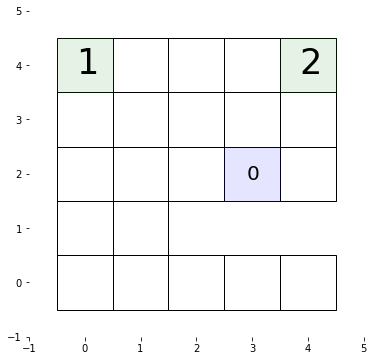

In [3]:
visualizeEnvironmentByState(stateSetC, goalStates = [world1Goal, world2Goal], trapStates = [], trajectory = [(3,2)], goalNameDictionary = {(0,4): "1", (4,4):"2"})

# Belief Transition Setup

In [4]:
#First build the position environment transition
getTransition = SetupDeterministicTransitionByStateSet(stateSetC, allActions)
environmentCTransitionTable = getTransition()

# Then build the belief transition
positionSet = stateSetC
beliefSet = [0,.5,1]  #our three belief states
observeSign = [(0,0), (1,0), (2,0), (3,0), (4,0)] #the positions where we will receive observations

getBeliefTransition = SetupBeliefTransition(positionSet, beliefSet, allActions, observeSign)
beliefTransitionTable = getBeliefTransition()

Key transition examples

In [5]:
# from position (1,1) with agnositic beliefs about where heaven is, if the agent moves down it will be in a 
# position to see the sign, thus its beliefs MUST transition to either world 1 or world 2.
print('Start state (1,1), belief .5 \n')
viewDictionaryStructure(beliefTransitionTable[((1,1),.5)], 't_key')

Start state (1,1), belief .5 

action: (1, 0)
	next state: ((1, 1), 0.5)
		probability: 1
action: (0, 1)
	next state: ((1, 2), 0.5)
		probability: 1
action: (-1, 0)
	next state: ((0, 1), 0.5)
		probability: 1
action: (0, -1)
	next state: ((1, 0), 1)
		probability: 0.5
	next state: ((1, 0), 0)
		probability: 0.5
action: (0, 0)
	next state: ((1, 1), 0.5)
		probability: 1


In [6]:
# However, from position (1,1) if the belief state is already 1, 
#if the agent moves down it will be in a position to see the sign, 
#but it already has all the information the sign has to give as the only way to be in belief state 1 is to 
# KNOW that the p(world 1) = 1 (i.e. heaven is behind door 1)
print('Start state (1,1), belief 1 \n')
viewDictionaryStructure(beliefTransitionTable[((1,1),1)], 't_key')

Start state (1,1), belief 1 

action: (1, 0)
	next state: ((1, 1), 1)
		probability: 1
action: (0, 1)
	next state: ((1, 2), 1)
		probability: 1
action: (-1, 0)
	next state: ((0, 1), 1)
		probability: 1
action: (0, -1)
	next state: ((1, 0), 1)
		probability: 1
action: (0, 0)
	next state: ((1, 1), 1)
		probability: 1


# Belief Reward Setup

## Typical Reward - State action based

In [7]:
#the reward structure if we were in world 1: Heaven is behind door 1
getWorld1Reward = SetupStateActionRewardTableWithDistanceMoveCost(stateSetC, allActions, [world1Goal], [world2Goal])
rewardofWorld1 = getWorld1Reward(50,-50)

#the reward structure if we were in world 2: Heaven is behind door 2
getWorld2Reward = SetupStateActionRewardTableWithDistanceMoveCost(stateSetC, allActions,[world2Goal], [world1Goal])
rewardofWorld2 = getWorld2Reward(50,-50)

## Belief Reward Rho

In [8]:
getRewardBeliefs = SetupRewardBeliefTable(positionSet, beliefSet, allActions)
rhoReward = getRewardBeliefs(beliefTransitionTable, [rewardofWorld1, rewardofWorld2])

Key belief reward examples - what the reward of door 1 is depending on what the belief state is

In [9]:
print('Start state (0,3), belief 1 \n')
viewDictionaryStructure(rhoReward[((0,4),1)], 'r_key')

Start state (0,3), belief 1 

action: (1, 0)
	next state: ((1, 4), 1)
		reward: 50
action: (0, 1)
	next state: ((0, 4), 1)
		reward: 50
action: (-1, 0)
	next state: ((0, 4), 1)
		reward: 50
action: (0, -1)
	next state: ((0, 3), 1)
		reward: 50
action: (0, 0)
	next state: ((0, 4), 1)
		reward: 50.0


In [10]:
print('Start state (0,3), belief .5 \n')
viewDictionaryStructure(rhoReward[((0,4),.5)], 'r_key')

Start state (0,3), belief .5 

action: (1, 0)
	next state: ((1, 4), 0.5)
		reward: -0.5
action: (0, 1)
	next state: ((0, 4), 0.5)
		reward: -0.5
action: (-1, 0)
	next state: ((0, 4), 0.5)
		reward: -0.5
action: (0, -1)
	next state: ((0, 3), 0.5)
		reward: -0.5
action: (0, 0)
	next state: ((0, 4), 0.5)
		reward: -0.05000000000000071


In [11]:
print('Start state (0,3), belief 0 \n')
viewDictionaryStructure(rhoReward[((0,4),0)], 'r_key')

Start state (0,3), belief 0 

action: (1, 0)
	next state: ((1, 4), 0)
		reward: -51
action: (0, 1)
	next state: ((0, 4), 0)
		reward: -51
action: (-1, 0)
	next state: ((0, 4), 0)
		reward: -51
action: (0, -1)
	next state: ((0, 3), 0)
		reward: -51
action: (0, 0)
	next state: ((0, 4), 0)
		reward: -50.1


# Value Iteration
It is important to note that value iteration is a dynamic programming method, creating a plan for all possible scenarios. Thus, in this step and all of the previous ones, we do NOT need to know what the actual observation/world is. We have a plan for either once we encounter the actual world with the sign. Thus, until we sample a trajectory in the world,we do not decide what the sign should say.

In [12]:
valueTable = {state:0 for state in beliefTransitionTable.keys()}

getPolicyA = DeterministicValueIteration(beliefTransitionTable, rhoReward, valueTable, 10e-7)
optimalValuesA, policyA = getPolicyA()

The visualization function is a 2D position representation, so we can only observe one belief state at a time for the entire set of position states

Therefore, we present 3 position grids, each corresponding to a different belief state. The coloring of the heaven and hell doors represent which belief state the agent is in.

Belief state = 1, heaven is behind door 1 at (0,4)


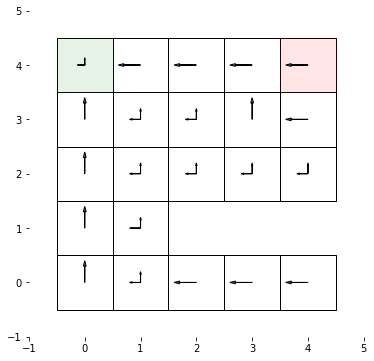

Belief state = .5, location of heaven is unknown


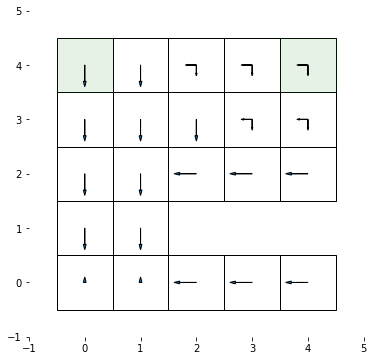

Belief state = 0, heaven is behind door 2 at (4,4)


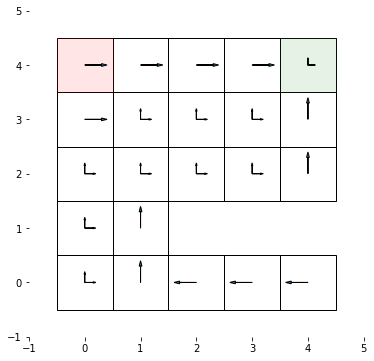

In [13]:
print('Belief state = 1, heaven is behind door 1 at (0,4)')
visualizePolicyOfBeliefByState(positionSet,policyA, 1,[world1Goal], [world2Goal])
print('Belief state = .5, location of heaven is unknown')
visualizePolicyOfBeliefByState(positionSet,policyA, .5,[world1Goal,world2Goal], [])
print('Belief state = 0, heaven is behind door 2 at (4,4)')
visualizePolicyOfBeliefByState(positionSet,policyA, 0,[world2Goal], [world1Goal])

# Path Sampling
At this point we might want to put our agent in a scenario where it must actually move in an environment, collect an observation, and decide how to act on it. Thus we can use the samplePathToGoal function, to sample from our trnasition and policy to see how the agent will act.

In [14]:
"""
    INPUTS: position, belief are the intial locational position and beliefs the agent has
            policy - the policy the agent follows
            transition - the belief transition describing the dynamics of the world
            goals -  list of location of the possible goals in the world
            observationOnSign - the TRUE world, representat as p(world1) = heaven, either 1 or 0
                This constrains our transition when we observe the sign.
    OUTPUTS: a list of position trajectories starting from the initial
            
"""
def samplePathToGoal(position, belief, policy, transition, goals, trueProbHeavenBehindDoor1):
    if belief != .5:
        assert belief == trueProbHeavenBehindDoor1, "the intial belief state is inconsistent with the observable signage"
    trajectory = [(position, belief)]

    while position not in goals:
        #take action probabilisitically
        actions = list(policy[(position, belief)].keys())
        probOfAction = [policy[(position, belief)][action] for action in actions]
        actionIndex = np.random.choice(len(actions), 1, p = probOfAction)
        sampledAction = actions[int(actionIndex)]
        
        #get new position and belief
        if len(list(transition[(position, belief)][sampledAction].keys())) > 1:
            newBelief = trueProbHeavenBehindDoor1
        else:
            newBelief = list(transition[(position, belief)][sampledAction].keys())[0][1]
        newPosition = list(transition[(position, belief)][sampledAction].keys())[0][0]        
        
        #update to new belief/position and add to trajectory
        belief = newBelief
        position = newPosition
        trajectory.append((position, belief))
    return(trajectory)

In [15]:
# User specified
startXYPosition = (3,2)
startBelief = .5 # or 0, or 1 if already knows content of sign
signInfo = 1 # or 1, probability of door 1 being heaven, must be consistent with starting belief

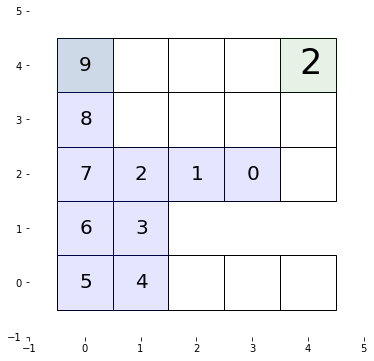

In [16]:
# sample a trajectory and visualize it
path = samplePathToGoal(startXYPosition, startBelief, policyA, beliefTransitionTable, [world1Goal, world2Goal], signInfo)
xyPositionTrajectory = [pos for pos, belief in path]
visualizeEnvironmentByState(stateSetC, goalStates = [world1Goal, world2Goal], trapStates = [], trajectory = xyPositionTrajectory, goalNameDictionary = {(4,3): "1", (4,4):"2"})